# risklearning demo

Most, if not all, operational risk capital models assume the existence of stationary frequency and severity distributions (typically Poisson for frequencies, and a subexponential distribution such as lognormal for severities). Yet every quarter (or whenever the model is recalibrated) risk capital goes up almost without fail, either because frequencies increase, severities increase or both.

The assumption of stationary distributions is just one limitation of current approaches to operational risk modeling, but it offers a good inroad for modeling approaches beyond the usual actuarial model typical in operational capital models.

In this notebook, we give a first example of how neural networks can overcome the stationarity assumptions of traditional approaches. The hope is that this is but one of many examples showing a better way to model operational risk.

Note: What follows if very much a work in progress . . .



In [25]:
import risklearning.learning_frequency as rlf
reload(rlf)

<module 'risklearning.learning_frequency' from 'risklearning/learning_frequency.pyc'>

In [53]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import matplotlib
matplotlib.style.use('ggplot')
import ggplot as gg
%matplotlib inline

## Set up frequency distribution to generate samples

In [27]:
tenors_horizon = 365 # (Time) tenors (e.g. 1 day) per model horizon (e.g. 1 year)

h_start = 5.0 # How many model horizons of past data to train
h_end = 1.0 #How many model horizons of past data to test / validate

# Present is tenor 0, and boundary between training and testing data sets
t_start = -int(math.floor(h_start*tenors_horizon))
t_end = int(math.floor(h_end*tenors_horizon))


#% Generate Poisson-distributed events
lambda_init = 1 # intensity over tenor (e.g. day)
lambda_final = 4 # intensity over tenor (e.g. day)
n_tenors = t_end - t_start
lambda_ts = np.linspace(lambda_init, lambda_final, num=n_tenors)
freq_rv = stats.poisson
counts = rlf.sim_counts(lambda_ts, freq_rv)

# Build df around counts, level 1 and 2 categorization of Operational Risk events
l1s = ['Execution Delivery and Process Management']*n_tenors
l2s = ['Transaction Capture, Execution and Maintenance']*n_tenors
tenors = list(xrange(t_start, t_end))

counts_sim_df = pd.DataFrame({'t': tenors,
                              'OR Category L1': l1s, 'OR Category L2': l2s,
                              'counts': counts})


In [28]:
                    
#%% Do MLE (simple average for Poisson process
n_tenors_train = -t_start
n_tenors_test = t_end

counts_train = (counts_sim_df[counts_sim_df.t < 0]).groupby('OR Category L2').sum()
counts_test =  (counts_sim_df[counts_sim_df.t >= 0]).groupby('OR Category L2').sum()


## MLE for training data

For the Poisson distribution, the MLE of the intensity (here lambda) is just the average of the counts per model horizon. In practice, OpRisk models sometimes take a weighted average, with the weight linearly decreasing over a period of years (see e.g. "LDA at Work" by Aue and Kalkbrener).

In [29]:
lambdas_train = counts_train['counts']/n_tenors_train
lambdas_test = counts_train['counts']/n_tenors_test

bin_tops = [1,2,3,4,5,6,7,8,9,10,15,101]
# Recall that digitize (used later) defines bins by lower <= x < upper
count_tops =[count - 1 for count in bin_tops]

# Calculate bin probabilities from MLE poisson
poi_mle = stats.poisson(lambdas_train)
poi_bins = rlf.bin_probs(poi_mle, bin_tops)

mle_probs = pd.DataFrame({'Count Top': count_tops, 'Probs': poi_bins})
# For later comparison
mle_probs_vals = list(mle_probs.Probs)

## Prep simulated losses for neural network

For example

* Use one-hot-encoding for L1 and L2 categories (this will make more sense once we look at multiple dependent categories)
* Bin count data
* Normalize tenors (i.e. scale so that first tenor maps to -1 with 0 preserved)
* Export as numpy arrays to feed into keras / tensorflow

In [30]:
import warnings
warnings.filterwarnings('ignore') # TODO: improve slicing to avoid warnings

x_train, y_train, x_test, y_test = rlf.prep_count_data(counts_sim_df, bin_tops)


## Set up the network architecture and train

We use keras with TensorFlow backend. Later we will look at optimizing metaparameters.


In [32]:
#from keras.optimizers import SGD
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# rl_train_net is a wrapper for standard keras functionality that
# makes it easier below to optimize hyperparameters
rl_net = rlf.rl_train_net(x_train, y_train, x_test, y_test, [150], \
                    n_epoch = 200, optimizer = 'adagrad')


160/365 [============>.................] - ETA: 0s

## Neural network frequency distribution

If the neural network has learned anything, we will see that the probility distribution shifts over time to higher buckets.

In [33]:
proba = rl_net['probs_nn']

In [34]:
nn_probs = pd.DataFrame(proba, index = range(0,t_end), columns = [t-1 for t in bin_tops])
# Heads (i.e. starting from present)
nn_probs.head()

,0,1,2,3,4,5,6,7,8,9,14,100
0,0.041510,0.149240,0.209815,0.211667,0.178780,0.101456,0.050101,0.040757,0.012466,0.002218,0.001915,0.000075
1,0.041485,0.149212,0.209782,0.211663,0.178824,0.101468,0.050116,0.040768,0.012472,0.002219,0.001916,0.000075
2,0.041460,0.149184,0.209749,0.211658,0.178868,0.101480,0.050132,0.040779,0.012479,0.002220,0.001916,0.000075
3,0.041435,0.149155,0.209717,0.211653,0.178912,0.101492,0.050147,0.040790,0.012485,0.002221,0.001916,0.000075
4,0.041410,0.149127,0.209684,0.211649,0.178956,0.101504,0.050163,0.040802,0.012492,0.002222,0.001917,0.000075


In [35]:
# Tails (i.e. going to end of model horizon of 1 yr)
nn_probs.tail()

,0,1,2,3,4,5,6,7,8,9,14,100
360,0.033738,0.139761,0.204032,0.210628,0.192738,0.104286,0.053711,0.043331,0.013595,0.002322,0.001808,0.00005
361,0.033719,0.139735,0.204024,0.210633,0.192774,0.104292,0.053715,0.043334,0.013596,0.002322,0.001807,0.00005
362,0.033700,0.139709,0.204016,0.210638,0.192809,0.104298,0.053719,0.043337,0.013596,0.002322,0.001806,0.00005
363,0.033681,0.139683,0.204008,0.210643,0.192845,0.104304,0.053723,0.043339,0.013597,0.002321,0.001806,0.00005
364,0.033662,0.139657,0.204001,0.210648,0.192881,0.104310,0.053728,0.043342,0.013597,0.002321,0.001805,0.00005


In [36]:
# And what MLE told us before
mle_probs.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11
Count Top,0.000000,1.00000,2.0000,3.0000,4.000000,5.000000,6.000000,7.00000,8.000000,9.000000,14.000000,1.000000e+02
Probs,0.107278,0.23948,0.2673,0.1989,0.111003,0.049559,0.018439,0.00588,0.001641,0.000407,0.000113,1.621801e-08


## Evaluating the neural network
The above shows that the neural network learns that counts increase over time, but we want more than just the correct trend, we want to see how far the neural network is from the true distribution, and compare with the MLE fitted distribution.

We do this both numerically (Kullback-Leibler divergance) and graphically.

In [37]:
#% Convert proba from wide to long and append to other probs
mle_probs_vals = list(mle_probs.Probs)
# TODO: Missing last tenor in nn proba (already in x_test, y_test)
probs_list = []
kl_mle_list = []
kl_nn_list = []

for t in range(proba.shape[0]):
    nn_probs_t = proba[t]    
    true_bins_t = rlf.bin_probs(stats.poisson(lambda_ts[-t_start+t]), bin_tops)
    probs_t = pd.DataFrame({'Tenor': t, 'Count Top': count_tops, \
                            'Probs True': true_bins_t, \
                            'Probs NN': nn_probs_t, \
                            'Probs MLE': mle_probs_vals}, \
                            index = range(t*len(count_tops), \
                                    t*len(count_tops) + len(count_tops)))
    probs_list.append(probs_t)
    # Calculate KL divergences
    kl_mle_list.append(stats.entropy(true_bins_t, mle_probs_vals))
    kl_nn_list.append(stats.entropy(true_bins_t, nn_probs_t))

probs = pd.concat(probs_list)


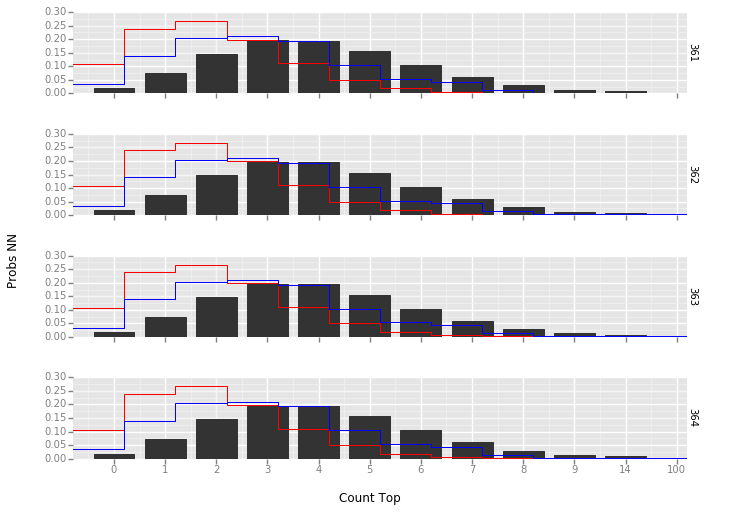

<ggplot: (8728194119009)>

In [38]:
probs_tail = probs[probs.Tenor > 360 ]

gg.ggplot(probs_tail, gg.aes(x='Count Top',weight='Probs True')) \
    + gg.facet_grid('Tenor') \
    + gg.geom_bar() \
    + gg.geom_step(gg.aes(y='Probs MLE', color = 'red')) \
    + gg.geom_step(gg.aes(y='Probs NN', color = 'blue')) \
    + gg.scale_x_continuous(limits = (0,len(count_tops)))



     KL MLE     KL NN  Tenor
0  0.306709  0.025236      0
1  0.307325  0.025342      1
2  0.307942  0.025449      2
3  0.308559  0.025556      3
4  0.309177  0.025663      4
       KL MLE     KL NN  Tenor
360  0.561459  0.089499    360
361  0.562254  0.089759    361
362  0.563050  0.090020    362
363  0.563846  0.090281    363
364  0.564642  0.090542    364


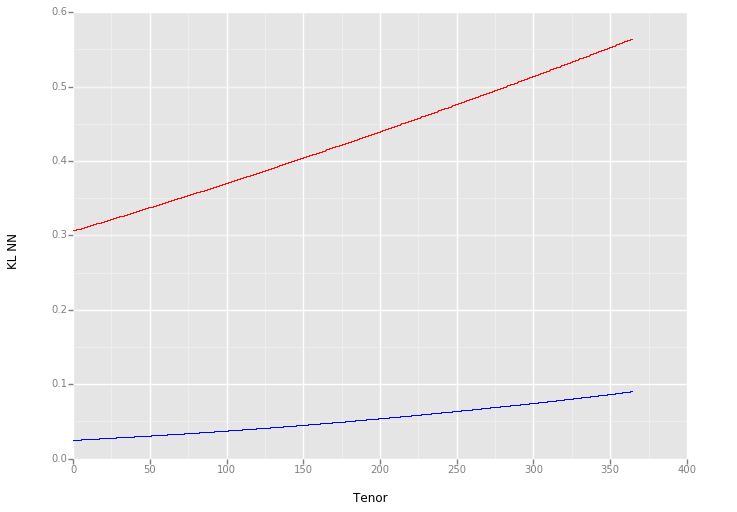

<ggplot: (8728191264637)>

In [39]:
# KL divergences

kl_df = pd.DataFrame({'Tenor': range(0, t_end), \
                      'KL MLE': kl_mle_list, \
                      'KL NN': kl_nn_list})

print kl_df.head()

print kl_df.tail()                      
#%                      
# Plot KL divergences
gg.ggplot(kl_df, gg.aes(x='Tenor')) \
    + gg.geom_step(gg.aes(y='KL MLE', color = 'red')) \
    + gg.geom_step(gg.aes(y='KL NN', color = 'blue'))

# Optimizing network architecture

In [61]:
# More systematically with NN architecture
# Loop over different architectures, create panel plot
neurons_list = [10, 20,50,100, 200]
#neurons_list = [10, 20,50]
depths_list = [1,2,3]
optimizer = 'adagrad'
#%%
kl_df_list = []
for depth in depths_list:
    for n_neurons in neurons_list:
        nn_arch = [n_neurons]*depth
        print("Training " + str(depth) + " layer(s) of " + str(n_neurons) + " neurons")
        rl_net = rlf.rl_train_net(x_train, y_train, x_test, y_test, nn_arch, \
                    n_epoch = 200, optimizer = optimizer)
        proba = rl_net['probs_nn']
        print("\nPredicting with " + str(depth) + " layer(s) of " + str(n_neurons) + " neurons")
        probs_kl_dict = rlf.probs_kl(proba, lambda_ts, t_start, t_end, bin_tops, mle_probs_vals)
        probs = probs_kl_dict['Probs']
        kl_df_n = probs_kl_dict['KL df']
    
        kl_df_n['Hidden layers'] = depth
        kl_df_n['Neurons per layer'] = n_neurons
        kl_df_n['Architecture'] = str(depth) + '_layers_of_' + str(n_neurons) \
            + '_neurons'

        kl_df_list.append(kl_df_n)
 #%%
kl_df_hyper = pd.concat(kl_df_list)

Training 1 layer(s) of 10 neurons
 32/365 [=>............................] - ETA: 10s
Predicting with 1 layer(s) of 10 neurons
Training 1 layer(s) of 20 neurons
 32/365 [=>............................] - ETA: 10s
Predicting with 1 layer(s) of 20 neurons
Training 1 layer(s) of 50 neurons
352/365 [===========================>..] - ETA: 0s
Predicting with 1 layer(s) of 50 neurons
Training 1 layer(s) of 100 neurons
352/365 [===========================>..] - ETA: 0s 
Predicting with 1 layer(s) of 100 neurons
Training 1 layer(s) of 200 neurons
352/365 [===========================>..] - ETA: 0s
Predicting with 1 layer(s) of 200 neurons
Training 2 layer(s) of 10 neurons
 32/365 [=>............................] - ETA: 11s
Predicting with 2 layer(s) of 10 neurons
Training 2 layer(s) of 20 neurons
 32/365 [=>............................] - ETA: 11s
Predicting with 2 layer(s) of 20 neurons
Training 2 layer(s) of 50 neurons
352/365 [===========================>..] - ETA: 0s 
Predicting with 2 layer

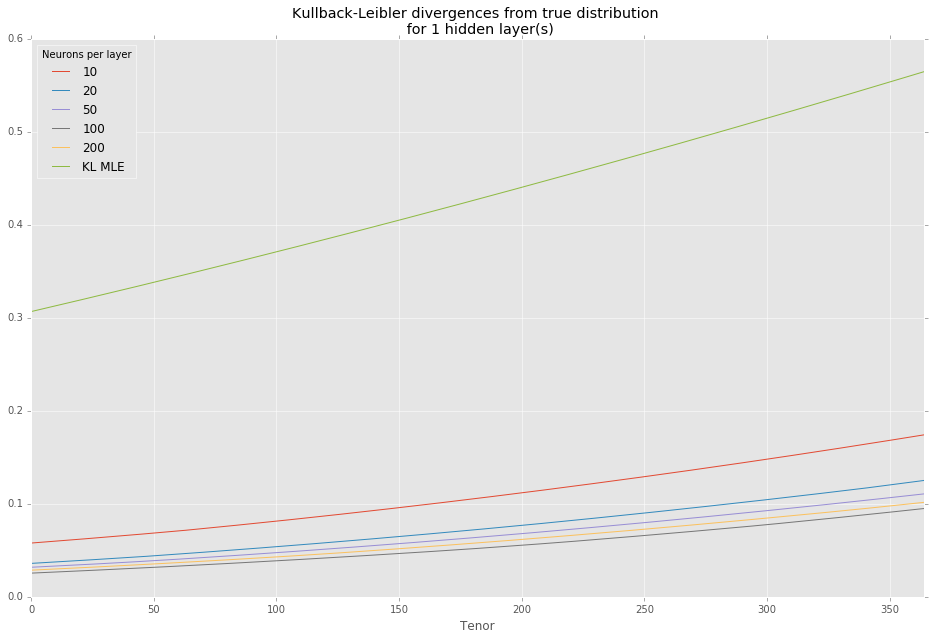

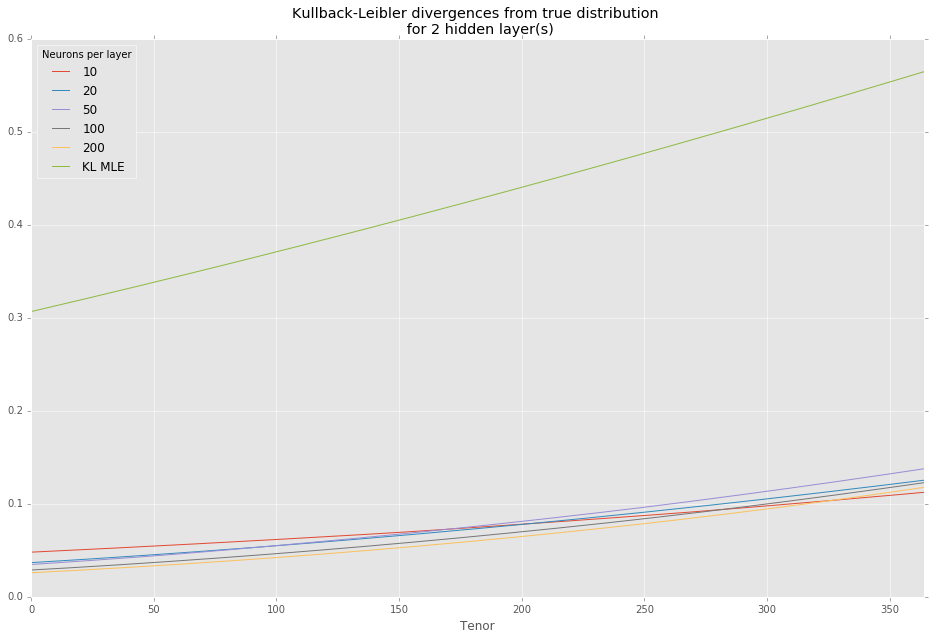

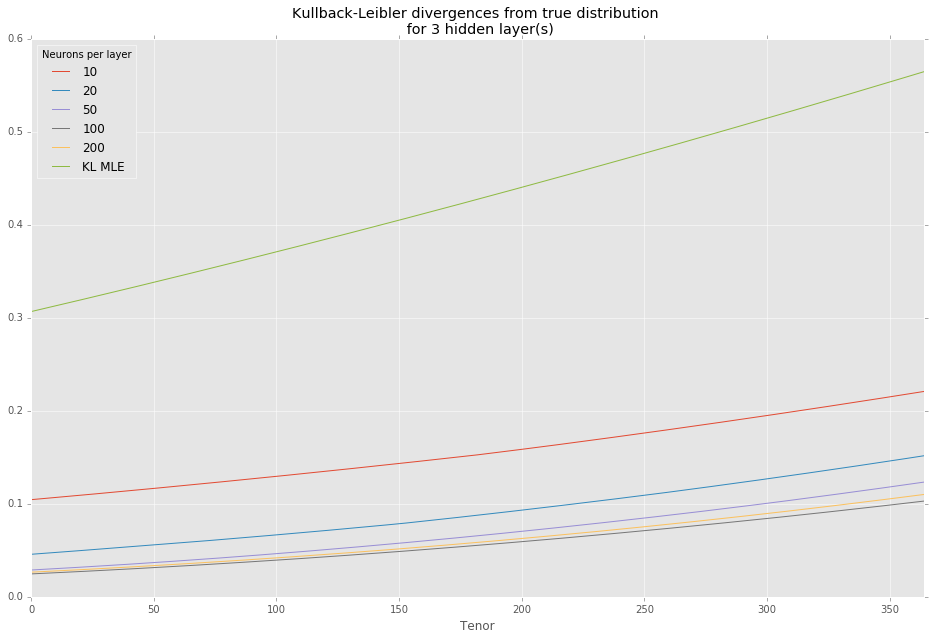

In [67]:
# Plot
kl_mle = kl_df_n['KL MLE'] # These values are constant over the above loops (KL between MLE and true distribution)
for depth in depths_list:
    kl_df_depth = kl_df_hyper[kl_df_hyper['Hidden layers'] == depth]
    kl_df_depth = kl_df_hyper[kl_df_hyper['Hidden layers'] == depth]
    kl_depth_vals = kl_df_depth.pivot(index = 'Tenor', columns = 'Neurons per layer', values = 'KL NN')
    kl_depth_vals['KL MLE'] = kl_mle
    kl_depth_vals.plot(title = 'Kullback-Leibler divergences from true distribution \n for ' \
                       + str(depth) + ' hidden layer(s)', \
                      figsize = (16,10))


## Summary and next steps

We can see by the nn_probs data frame that the probability mass of the neural network shifts to the right, as does the underlying Poisson processes, with its intensity starting at 1 events per tenor / day at - 5 yrs and ending at 4 events per tenor / day at +1 yrs.

Next steps:

* Simulate multiple, correlated Poisson processes
* Test different optimizers
* Test non-linear non-stationarities
* Try recurrent neural network (?)
* Try convolution network (?)

